In [179]:
import numpy as np
import sympy as sp
import roboticstoolbox as rtb
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn import metrics

### Matrices de transformacion

In [2]:
def sTrasl(x, y, z):
    """ Transformación homogénea que representa traslación pura
    """
    T = sp.Matrix([[1,0,0,x],
                   [0,1,0,y],
                   [0,0,1,z],
                   [0,0,0,1]])
    return T

def sTrotx(ang):
    """ Transformación homogénea que representa rotación alrededor de x
    """
    T = sp.Matrix([[1, 0,0,0],
                   [0, sp.cos(ang),-sp.sin(ang),0],
                   [0, sp.sin(ang), sp.cos(ang),0],
                   [0, 0, 0, 1]])
    return T

def sTrotz(ang):
    """ Transformación homogénea que representa rotación alrededor de z
    """
    T = sp.Matrix([[sp.cos(ang),-sp.sin(ang),0,0],
                   [sp.sin(ang), sp.cos(ang),0,0],
                   [0,0,1,0],
                   [0,0,0,1]])
    return T

In [3]:
# Variables que serán utilizadas
q1, q2, q3, q4, q5, q6 = sp.symbols("q1 q2 q3 q4 q5 q6")
l1, l2, l3, l4, l5, l6 = sp.symbols("l1 l2 l3 l4 l5 l6")

cos, sin = sp.cos, sp.sin
# Transformaciones con respecto al sistema anterior
T01 = sp.Matrix([
    [cos(q1), 0, -sin(q1), 0],
    [sin(q1), 0, cos(q1), 0],
    [0,-1,0, l1],
    [0,0,0,1]
])
 
T12 = sp.Matrix([
  [sin(q2), cos(q2), 0, l2*sin(q2)],
  [-cos(q2), sin(q2), 0, -l2*cos(q2)],
  [0,0,1,0],
  [0,0,0,1]
])

T23 = sp.Matrix([
    [cos(q3), 0, -sin(q3), l3*cos(q3)],
    [sin(q3), 0, cos(q3), l3*sin(q3)],
    [0,-1,0,0],
    [0,0,0,1]
])

T34 = sp.Matrix([
    [cos(q4), 0, sin(q4), 0],
    [sin(q4), 0, -cos(q4), 0],
    [0,1,0,l4],
    [0,0,0,1]
])

T45 = sp.Matrix([
    [cos(q5), 0, -sin(q5), 0],
    [sin(q5), 0, cos(q5), 0],
    [0, -1, 0, 0],
    [0,0,0,1]
])

T56 = sp.Matrix([
    [cos(q6), -sin(q6), 0, 0],
    [sin(q6), cos(q6), 0,0],
    [0,0,1,l6],
    [0,0,0,1]
])

T06 = sp.simplify(T01*T12*T23*T34*T45*T56)

print("T01:"); display(T01)
print("T12:"); display(T12)
print("T23:"); display(T23)
print("T34:"); display(T34)
print("T45:"); display(T45)
print("T56:"); display(T56)

T01:


Matrix([
[cos(q1),  0, -sin(q1),  0],
[sin(q1),  0,  cos(q1),  0],
[      0, -1,        0, l1],
[      0,  0,        0,  1]])

T12:


Matrix([
[ sin(q2), cos(q2), 0,  l2*sin(q2)],
[-cos(q2), sin(q2), 0, -l2*cos(q2)],
[       0,       0, 1,           0],
[       0,       0, 0,           1]])

T23:


Matrix([
[cos(q3),  0, -sin(q3), l3*cos(q3)],
[sin(q3),  0,  cos(q3), l3*sin(q3)],
[      0, -1,        0,          0],
[      0,  0,        0,          1]])

T34:


Matrix([
[cos(q4), 0,  sin(q4),  0],
[sin(q4), 0, -cos(q4),  0],
[      0, 1,        0, l4],
[      0, 0,        0,  1]])

T45:


Matrix([
[cos(q5),  0, -sin(q5), 0],
[sin(q5),  0,  cos(q5), 0],
[      0, -1,        0, 0],
[      0,  0,        0, 1]])

T56:


Matrix([
[cos(q6), -sin(q6), 0,  0],
[sin(q6),  cos(q6), 0,  0],
[      0,        0, 1, l6],
[      0,        0, 0,  1]])

#### Matriz de transformacion de todo el robot

In [4]:
print("T06:"); display(T06)

T06:


Matrix([
[((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*cos(q6) - (-sin(q1)*cos(q4) + sin(q4)*sin(q2 + q3)*cos(q1))*sin(q6), -((sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*cos(q5) + sin(q5)*cos(q1)*cos(q2 + q3))*sin(q6) + (sin(q1)*cos(q4) - sin(q4)*sin(q2 + q3)*cos(q1))*cos(q6), -(sin(q1)*sin(q4) + sin(q2 + q3)*cos(q1)*cos(q4))*sin(q5) + cos(q1)*cos(q5)*cos(q2 + q3), l2*sin(q2)*cos(q1) + l3*sin(q2 + q3)*cos(q1) + l4*cos(q1)*cos(q2 + q3) - l6*sin(q1)*sin(q4)*sin(q5) - l6*sin(q5)*sin(q2 + q3)*cos(q1)*cos(q4) + l6*cos(q1)*cos(q5)*cos(q2 + q3)],
[ ((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*cos(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*sin(q6), -((sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*cos(q5) + sin(q1)*sin(q5)*cos(q2 + q3))*sin(q6) - (sin(q1)*sin(q4)*sin(q2 + q3) + cos(q1)*cos(q4))*cos(q6), -(sin(q1)*sin(q2 + q3)*cos(q4) - sin(q4)*cos(q1))*sin(q5) + sin(q1)*cos(q5)*cos(q2 + 

### Clase y parametros DH para el robot con roboticstoolbox

In [5]:
class IRB120(rtb.DHRobot):

    q0 = [0,0,0,0,0,0] #Valores de q para posicion inicial
    
    def __init__(self):
        super().__init__(                
                [
                    rtb.RevoluteDH(offset=0, d=0.290, a=0,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=-np.pi/2, d=0, a=0.27,alpha=0),
                    rtb.RevoluteDH(offset=0, d=0, a=0.07,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0.302, a=0,alpha=np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0, a=0,alpha=-np.pi/2),
                    rtb.RevoluteDH(offset=0, d=0.072, a=0,alpha=0),
                ], name="IRB 120"
                        )
robot = IRB120()
robot

DHRobot: IRB 120, 6 joints (RRRRRR), dynamics, standard DH parameters
┌──────────┬───────┬──────┬────────┐
│   θⱼ     │  dⱼ   │  aⱼ  │   ⍺ⱼ   │
├──────────┼───────┼──────┼────────┤
│ q1       │  0.29 │    0 │ -90.0° │
│ q2 - 90° │     0 │ 0.27 │   0.0° │
│ q3       │     0 │ 0.07 │ -90.0° │
│ q4       │ 0.302 │    0 │  90.0° │
│ q5       │     0 │    0 │ -90.0° │
│ q6       │ 0.072 │    0 │   0.0° │
└──────────┴───────┴──────┴────────┘

┌─┬──┐
└─┴──┘

In [6]:
robot.fkine([-1.51, -0.763, 1.85, -0.817, 0.9120, 2.320])

  -0.8055    0.07948  -0.5873   -0.04132   
  -0.01848   0.9871    0.1589   -0.004371  
   0.5923    0.1389   -0.7936    0.1932    
   0         0         0         1         


In [7]:
t06 = T06.evalf(subs={q1:-1.51, q2:-0.763, q3:1.85, q4:-0.817, q5:0.912, q6:2.3, l1: 0.29, l2:0.27, l3:0.07, l4:0.302, l5:0, l6:0.072})
final = np.array(t06).astype(np.float64)
final

array([[-0.80691514,  0.0633539 , -0.58725994, -0.04132001],
       [-0.03821904,  0.98654765,  0.15894353, -0.00437144],
       [ 0.5894296 ,  0.15069845, -0.79363891,  0.19322372],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Lectura de datos

In [201]:
data = pd.read_csv('datos_IRB120.csv')
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,X,Y,Z
0,2.0719,0.3370,1.4658,1.0830,-0.6027,-0.0833,-0.01303,0.09884,0.17269
1,2.5567,-1.3228,0.2362,-1.1321,-0.2603,-2.8035,0.12222,-0.10105,0.72139
2,0.8895,0.4842,1.5584,-0.0810,-0.9872,-3.0114,0.05044,0.06993,0.16558
3,2.2722,-0.2935,0.2632,0.3556,1.4149,-0.6962,-0.17045,0.16341,0.56126
4,0.6049,-1.2290,1.1041,-0.9225,1.5361,2.5172,0.06917,-0.02191,0.44478


In [203]:
robot.fkine([2.2722,	-0.2935,	0.2632,	0.3556,	1.4149,	-0.6962])

  -0.9099    0.1639   -0.381    -0.1704    
   0.2099    0.9743   -0.08194   0.1634    
   0.3578   -0.1545   -0.9209    0.5613    
   0         0         0         1         


#### Separando datos de labels

In [204]:
data.shape

(100000, 9)

In [205]:
X = data.loc[:, ['X', 'Y', 'Z']]
y = data.loc[:,['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']]

In [206]:
X.shape

(100000, 3)

In [207]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_tensors = torch.from_numpy(X.values).float().to(device)
y_tensors = torch.from_numpy(y.values).float().to(device)

X_train, X_test, y_train, y_test = train_test_split(X_tensors, y_tensors, test_size=0.2, train_size=0.8, random_state=12)

In [209]:
X_test.shape

torch.Size([20000, 3])

In [125]:
class IRB120_dataset(Dataset):

    def __init__(self, X_train, y_train):
        self.x_data, self.y_data = X_train, y_train
  
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

    def __len__(self):
      return len(self.y_data)

IRB_120_data = IRB120_dataset(X_train, y_train)

In [160]:
batch_size = 5000
loader = DataLoader(dataset=IRB_120_data, batch_size=batch_size, shuffle=True)

In [215]:
class IK_IRB120(nn.Module):

  def __init__(self):
    super(IK_IRB120, self).__init__()
    # input layer
    self.input_layer_to_hidden_layer_1 = nn.Linear(3, 8, bias=True)
    # relu 1
    self.relu1 = nn.ReLU()

    # hidden layer 1
    self.hidden_layer_1_to_hidden_layer_2 = nn.Linear(8, 12, bias=True)
    # relu 2
    self.relu2 = nn.ReLU()

    # hidden layer 2
    self.hidden_layer_2_to_hidden_layer_3 = nn.Linear(12, 16, bias = True)
    self.relu3 = nn.ReLU()

     # hidden layer 3
    self.hidden_layer_3_to_hidden_layer_4 = nn.Linear(16, 20, bias = True)
    self.relu3 = nn.ReLU()

     # hidden layer 4
    self.hidden_layer_4_to_hidden_layer_5 = nn.Linear(20, 12, bias = True)
    self.relu3 = nn.ReLU()

    # hidden layer 5
    self.hidden_layer_5_to_output_layer = nn.Linear(12, 6, bias = True)
    # Softmax
    self.softmax = nn.Softmax()

  def forward(self, input):

    # input layer
    linear_combination1 = self.input_layer_to_hidden_layer_1(input)
    intermediate_relu1 = self.relu1(linear_combination1)

    # hidden layer 1
    linear_combination2 = self.hidden_layer_1_to_hidden_layer_2(intermediate_relu1)
    intermediate_relu2 = self.relu2(linear_combination2)

    # hidden layer 2
    linear_combination3 = self.hidden_layer_2_to_hidden_layer_3(intermediate_relu2)
    intermediate_relu3 = self.relu3(linear_combination3)

    # hidden layer 3
    linear_combination3 = self.hidden_layer_3_to_hidden_layer_4(intermediate_relu3)
    intermediate_relu4 = self.relu3(linear_combination3)

    # hidden layer 4
    linear_combination4 = self.hidden_layer_4_to_hidden_layer_5(intermediate_relu4)
    intermediate_relu5 = self.relu3(linear_combination4)

    # hidden layer 5
    linear_combination5 = self.hidden_layer_5_to_output_layer(intermediate_relu5)
    out = self.softmax(linear_combination5)

    return out

#### Entrenamiento

In [190]:
irb120 = IK_IRB120().to(device)

In [191]:
epochs = 1000
optimizer = torch.optim.Adam(irb120.parameters(), lr = 0.01)
loss_function = torch.nn.MSELoss()

losses = []
for epoch in range(epochs):
  mini_batch_losses = []
  for i, (features, labels) in enumerate(loader):
   
    Y_prediction = irb120.forward(features)

    loss = loss_function(Y_prediction, labels) 

    irb120.zero_grad()

    loss.backward()

    optimizer.step()

    # keep track of losses
    mini_batch_losses.append(loss.detach().cpu().numpy()) # we can only execute numpy code on the cpu

  mini_batch_mean_loss = np.mean(mini_batch_losses)
  losses.append(mini_batch_mean_loss)
  if epoch % 100 == 0:
    print(f"Loss in Epoch {epoch}: {np.mean(losses)}")

/tmp/ipykernel_5577/427489765.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sofmax(linear_combination5)


Loss in Epoch 0: 1.4948912858963013
Loss in Epoch 100: 1.2879130840301514
Loss in Epoch 200: 1.2868791818618774
Loss in Epoch 300: 1.2865325212478638
Loss in Epoch 400: 1.28635835647583
Loss in Epoch 500: 1.2862540483474731
Loss in Epoch 600: 1.2861844301223755
Loss in Epoch 700: 1.2861346006393433
Loss in Epoch 800: 1.2860971689224243
Loss in Epoch 900: 1.286068081855774


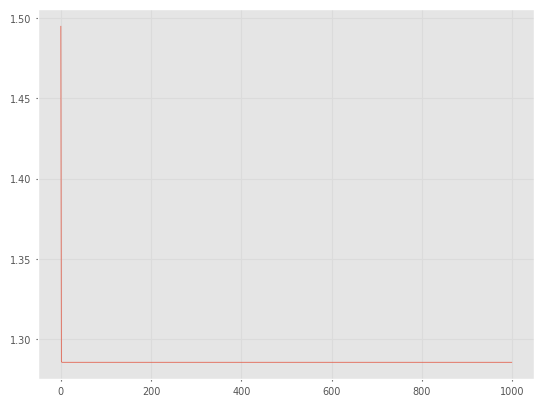

In [192]:
plt.figure()
plt.plot(losses)

#### Test

In [211]:
y_test_predictions = irb120.forward(X_test)

/tmp/ipykernel_5577/427489765.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sofmax(linear_combination5)


In [212]:
metrics.mean_squared_error(y_test.detach().cpu().numpy(), y_test_predictions.detach().cpu().numpy())

1.2887995

In [213]:
metrics.mean_absolute_error(y_test.detach().cpu().numpy(), y_test_predictions.detach().cpu().numpy())

0.9340578

In [214]:
with torch.no_grad():
    total_loss = 0.0
    for data in y_train:
        outputs = irb120.forward(X_test)
        loss = loss_function(outputs, y_test)
        total_loss += loss.item()

    print('Validation loss: %.3f' % (total_loss / len(y_test)))

/tmp/ipykernel_5577/427489765.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sofmax(linear_combination5)


Validation loss: 5.155


In [97]:
X_test.shape

torch.Size([2000, 3])

In [165]:
xd = torch.tensor([-0.01303, 0.09884, 0.1727])
pp = irb120.forward(xd)
pp

/tmp/ipykernel_5577/1296682034.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.sigmoid3(linear_combination4)


tensor([6.4980e-01, 6.0384e-03, 3.4416e-01, 2.1450e-09, 2.1755e-09, 3.6653e-09],
       grad_fn=<SoftmaxBackward0>)

In [166]:
robot.fkine(pp.detach().cpu().numpy())

   0.2732    0.605     0.7479    0.3001    
   0.2076   -0.7962    0.5683    0.2281    
   0.9393   -5.458e-09 -0.3431    0.4974    
   0         0         0         1         


In [149]:
robot.fkine([2.0719,	0.3370,	1.4658,	1.0830,	-0.6027,	-0.0833])

   0.3252    0.8541    0.406    -0.01303   
   0.8347   -0.461     0.3012    0.09884   
   0.4444    0.2409   -0.8628    0.1727    
   0         0         0         1         


In [66]:
accuracy = y_test-y_test_predictions

In [67]:
accuracy

tensor([[-0.4251,  0.0102, -0.0554],
        [-0.1212,  0.0154, -0.0502],
        [-0.3474, -0.0199,  0.0276],
        ...,
        [-0.0267, -0.0415, -0.0148],
        [-0.4361,  0.0031, -0.0011],
        [ 0.0222, -0.0313, -0.0281]], grad_fn=<SubBackward0>)